In [153]:
import requests
import gunicorn
import flask
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

API ini dinominasikan sebagai capstone project yang berguna untuk mengirimkan data kepada user. Proses wrangling dilakukan sesuai endpoint-endpoint dibawah. Base url dari aplikasi ini adalah

Endpoints: 

    1. /bestbook/ methods=['GET']
    Merupakan static endpoint untuk mengembalikan informasi dari books_c.csv dengan rating minimal 4  
    
    2. /rating_book/<value>methods=['GET']
    Merupakan dynamic endpoint untuk mengembalikan informasi dari books_c.csv dengan rating dibawah sesuai dengan keinginan kita dalam bentuk JSON
        
    3. /Genre2012/ methods=['GET']
    Merupakan static endpoint untuk mengembalikan informasi dari chinook.db untuk seluruh invoice dari tahun 2012 untuk genre 'Rock', 'Jazz', 'Metal'

API 1 (Best Book) : Best author(s)?
 - ada 3678 author yang termasuk dlm kategori ini. dicari dengan (unique().size())
 - ada banyak author yang hanya punya 1 buku tapi rating nya 5 karena sedikit 'ratings_count' dan	'text_reviews_count'. Sehingga, kalau diurutkan hanya dari rating, author2 ini lah yang rating nya paling tinggi. Padahal kita sama sekali tidak kenal author-author tsb.
 - lalu, bagaimana cara mencari 10 author terbaik?
 - hypothesis: author terbaik adalah yang rating nya tinggi dan banyak menerbitkan buku
 - buat 'total rating' dan 'mean_rating', lalu tampilkan urutan 'author' 'num_books' dan 'average_rating' berdasarkan 'total_rating'

In [16]:
url1 = 'http://localhost:5000/bestbook'
r = requests.get(url1)
r_bb = pd.DataFrame(r.json())
r_bb.head(15)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.56,0439785960,9780439785969,eng,652,1944099,26249
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.49,0439358078,9780439358071,eng,870,1996446,27613
2,3,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling,4.47,0439554934,9780439554930,eng,320,5629932,70390
3,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.41,0439554896,9780439554893,eng,352,6267,272
4,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling,4.55,043965548X,9780439655484,eng,435,2149872,33964
5,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling,4.78,0439682584,9780439682589,eng,2690,38872,154
7,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,27410,820
8,12,The Ultimate Hitchhiker's Guide: Five Complete...,Douglas Adams,4.38,0517226952,9780517226957,eng,815,3602,258
9,13,The Ultimate Hitchhiker's Guide to the Galaxy,Douglas Adams,4.38,0345453743,9780345453747,eng,815,240189,3954
10,14,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams,4.22,1400052920,9781400052929,eng,215,4416,408


In [12]:
r_bb.dtypes

bookID                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
# num_pages             int64
ratings_count           int64
text_reviews_count      int64
dtype: object

In [39]:
# r_bb['authors'].unique().size
r_bb1=r_bb.reset_index().set_index('authors').groupby(['authors']).sum().sort_values(by='average_rating', ascending=False)
r_bb1['total_rating']=r_bb1['average_rating']
r_bb1['num_books']=r_bb['authors'].value_counts()
r_bb1['mean_rating']=r_bb1['total_rating']/r_bb1['num_books']
r_bb1.head(20)

r_bb1.pivot_table(index='authors', values=['num_books','mean_rating','total_rating']).\
sort_values(by= 'total_rating', ascending=False).iloc[0:10,:]

,mean_rating,num_books,total_rating
authors,,,
Rumiko Takahashi,4.221136,44,185.73
P.G. Wodehouse,4.207500,36,151.47
J.R.R. Tolkien,4.400645,31,136.42
Stephen King,4.231667,30,126.95
J.K. Rowling,4.517826,23,103.91
Agatha Christie,4.160500,20,83.21
Mercedes Lackey,4.132500,20,82.65
Terry Pratchett,4.204211,19,79.88
Janet Evanovich,4.171579,19,79.26


API 2: Rating Book: Best Indie Book(s)?

- Saya bosan membaca buku-buku dari author terkenal, di waktu-waktu luang saya, saya ingin baca 10-20 buku dari author yang tidak terlalu terkenal tapi ada kemungkinan buku nya menarik!
- Hypothesis: 'average_rating' <= 3.5, 'num_pages' <= 150, 'text_reviews_count' dan 'ratings_count' nya tinggi
- ada 9970 buku dengan 779 author berbeda yang rating nya <=3.5 dicari dengan .unique().size 
- ada 2160 buku dengan 'num_pages' <= 150
- Kita drop column yang kurang perlu, lalu urutkan berdasarkan 'ratings_count', 'text_reviews_count', dan 'average_rating', respectively
- Conclusion: kita bisa lihat buku2 yang lumayan terkenal tapi gak mainstream seperti 'Death of a Salesman', 'Moby Dick',  atau 'Stationary Bike', dan 'Beowulf' utk 20 besar :)

In [64]:
url2 = 'http://localhost:5000/rating_book/3.5'
r = requests.get(url2)
r_rb = pd.DataFrame(r.json())
r_rb.dtypes
# r_rb.size
# r_rb['authors'].unique().size
# r_rb[r_rb['# num_pages']<= 150].head()

bookID                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
# num_pages             int64
ratings_count           int64
text_reviews_count      int64
dtype: object

In [69]:
r_rb1 = r_rb[r_rb['# num_pages']<= 150]
r_rb1.drop(['bookID','isbn','isbn13','language_code'], axis=1, inplace=True)
r_rb1.dtypes

C:\Users\FABIAN\.conda\envs\capstone-API\lib\site-packages\pandas\core\frame.py:4157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


title                  object
authors                object
average_rating        float64
# num_pages             int64
ratings_count           int64
text_reviews_count      int64
dtype: object

In [76]:
r_rb1.sort_values(['ratings_count', 'text_reviews_count', 'average_rating'],
                  ascending=[False, False, False]).iloc[0:10,:]

,title,authors,average_rating,# num_pages,ratings_count,text_reviews_count
1797,The Pearl,John Steinbeck,3.45,96,153111,5853
4240,Death of a Salesman,Arthur Miller,3.50,117,146272,2858
4265,The Turn of the Screw,Henry James,3.44,131,63700,3855
3504,Shopgirl,Steve Martin,3.42,130,29566,2135
4251,The Castle of Otranto,Horace Walpole,3.18,125,15390,1133
5618,The Final Solution,Michael Chabon-Jay Ryan,3.31,131,13455,1367
2264,The Comfort of Strangers,Ian McEwan,3.42,128,10331,804
828,Moby Dick,Herman Melville-William Hootkins,3.49,6,8872,900
2263,Black Dogs,Ian McEwan,3.44,149,7557,472
14,Bill Bryson's African Diary,Bill Bryson,3.43,55,6993,470


API 3: Genre Invoice

- saya adalah produser musik Rock. saya mau tahu musik rock itu laku di 'BillingCity' dan 'BillingCountry' mana saja selama tahun 2012, ditunjukkan dari berapa total belanja setiap 'CustomerId'
- Dalam data tersebut 'InvoiceDate' diubah menjadi 'datetime64'
- Dalam data tersebut 'BillingCity' dan 'BillingCountry' diubah menjadi 'category'
- Jika ada data 'None' akan diubah menjadi NaN dan di Drop
- Subset dilakukan hanya untuk tahun 2012 saja
- 'CustomerId' 26 dari Fort Worth USA adalah pembeli terbanyak musik Genre Rock
- USA menjadi negara pengkonsumi musik Rock tertinggi, disusul oleh Canada dan Brazil

In [217]:
url3 = 'http://localhost:5000/Genre2012/'
r = requests.get(url3)
r_g2 = pd.DataFrame(r.json())
r_g2['InvoiceDate'] = r_g2['InvoiceDate'].astype('datetime64')
r_g2[['BillingCountry','BillingCity']] = r_g2[['BillingCountry','BillingCity']].astype('category')

r_g20 = r_g2[r_g2['InvoiceDate'] <= '2013-01-01 00:00:00']
r_g20.tail()

,Genre,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total,InvoiceLineId
637864,Jazz,332,24,2012-12-30,162 E Superior Street,Chicago,IL,USA,60611,5.94,1798
637865,Jazz,332,24,2012-12-30,162 E Superior Street,Chicago,IL,USA,60611,5.94,1798
637866,Jazz,332,24,2012-12-30,162 E Superior Street,Chicago,IL,USA,60611,5.94,1798
637867,Jazz,332,24,2012-12-30,162 E Superior Street,Chicago,IL,USA,60611,5.94,1798
637868,Jazz,332,24,2012-12-30,162 E Superior Street,Chicago,IL,USA,60611,5.94,1798


In [215]:
r_g201 = r_g20.loc[:,['BillingCity','BillingState','BillingCountry']]
r_g201.melt()
# .reset_index().melt(value_vars=['BillingCity'],id_vars=['BillingCountry'])

,variable,value
0,BillingCity,Sidney
1,BillingCity,Sidney
2,BillingCity,Sidney
3,BillingCity,Sidney
4,BillingCity,Sidney
...,...,...
1739272,BillingCountry,USA
1739273,BillingCountry,USA
1739274,BillingCountry,USA
1739275,BillingCountry,USA


In [191]:
r_g2.groupby(['BillingCountry','BillingCity','CustomerId']).\
sum()['Total'].sort_values(ascending = False).head(10)

BillingCountry  BillingCity   CustomerId
USA             Fort Worth    26            542392.43
Czech Republic  Prague        6             475986.03
                              5             415286.43
France          Dijon         43            415286.43
Portugal        Lisbon        34            379022.31
USA             Orlando       22            366000.43
Argentina       Buenos Aires  56            360812.43
Sweden          Stockholm     51            360812.43
Denmark         Copenhagen    9             360812.43
France          Paris         39            360812.43
Name: Total, dtype: float64

<AxesSubplot:xlabel='BillingCountry'>

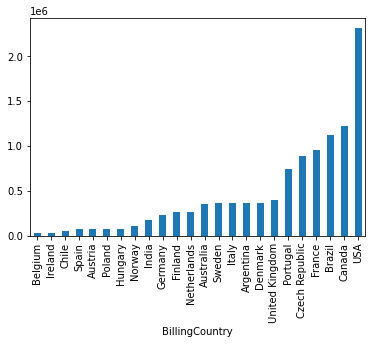

In [189]:
r_g20=r_g2.groupby('BillingCountry').sum()['Total'].sort_values(ascending = True).plot.bar()
r_g20